# Visualization - GradCam
**Author**: Hyeri

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

def img_to_tensor(img_path, img_size=(100,100,3), RGB=True):
    img = cv2.imread(img_path, 1)[...,::-1]
    img_tensor = cv2.resize(img, img_size[:2])
    img_tensor = np.float32(img_tensor) / 255 if RGB else img_tensor
    return np.float32(img_tensor)

def pp_result(cam, img_tensor, result):
    print(img_tensor.shape)
    print(cam.shape)
    _, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].set_title(result)
    axs[0].imshow(img_tensor)
    axs[0].imshow(cam, alpha=0.7)
    cam_adj = show_cam_on_image(img_tensor, cam)
    plt.title(result + ' (adjusted)')
    axs[1].imshow(cam_adj)
    plt.show()

In [2]:
labels_raf = {  0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }
labels_fer = {  0:  'NF',
                1:  'anger',
                2:  'comtempt',
                3:  'disgust',
                4:  'fear',
                5:  'happiness',
                6:  'neutral',
                7:  'sadness',
                8:  'surprise',
                9:  'unknown'
            }

## Path

In [3]:
model_fer = './models/model_ferplus_h.h5'
model_raf = './models/model_raf_h.h5'

input_model = model_fer

# 5, 6, 7, 10, 11, 13, 14, 16, 19, 22, 26
img_path = './data/RAF/images/test_0010_aligned.jpg'

## Image

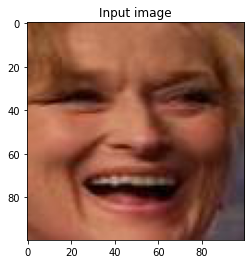

In [4]:
img_size = (100,100,3)

image = np.array(load_img(img_path, target_size=img_size))
plt.imshow(image)

img_size = (100,100,3)
img_tensor = img_to_tensor(img_path, img_size)
plt.title('Input image')
plt.imshow(img_tensor)

input_img_tensor = img_tensor[np.newaxis, ...]

# Model

In [5]:
model = load_model(input_model)
#print([layer.name for layer in model.layers])

classification_result = np.argmax(model.predict(input_img_tensor)[0])

2022-01-27 06:37:09.835698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-27 06:37:09.836039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-01-27 06:37:10.116729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-27 06:37:10.180267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [6]:
last_conv_layer_name = 'conv2d_7'
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ['batch_normalization_7', 'max_pooling2d_2', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1']:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [7]:
with tf.GradientTape() as tape:
    inputs = input_img_tensor
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

gradcam = np.mean(last_conv_layer_output, axis=-1)

gradcam = cv2.resize(gradcam, img_size[:2])

In [8]:
def scale_cam_image(img, target_size=(100,100)):
    img = img - np.min(img)
    img = img / (1e-7 + np.max(img))
    img = cv2.resize(img, target_size)
    result = np.float32(img)
    return result

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")
    cam = 0.7 * heatmap + img
    cam /= np.max(cam)
    return np.uint8(255 * cam)

(100, 100, 3)
(100, 100)


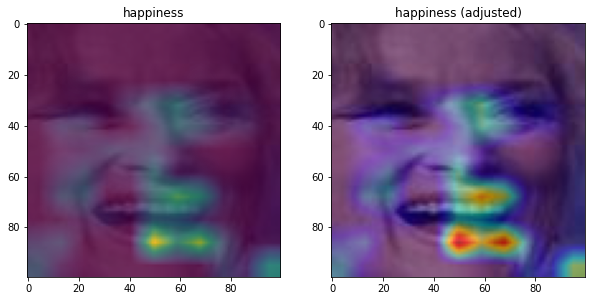

In [9]:
result = labels_raf[classification_result] if input_model==model_raf else labels_fer[classification_result]
pp_result(scale_cam_image(gradcam), img_tensor, result)